# An Introduction to SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data; A Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [References](#References)

# Introduction
***

This lab is adapted for learning purposes from [Amazon SageMaker Random Cut Forest and Anomaly Detection](https://github.com/aws/amazon-sagemaker-examples/tree/4b9615508a08b474d7a89827cb21d67c8f12ad1c/introduction_to_amazon_algorithms/random_cut_forest) example notebook.


Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

The RCF algorithm works great on large data sets.  It randomly selects a sampling of the data.  Each sampling is called a tree.  All the trees together define the forest.  Each tree is cut down into smaller and smaller sampling sizes.  Data points in each sample are assigned an anomaly score dependent on how many times the tree had to be cut and if the sampling size surpassed three standard deviations[2] from the overall sample.

In this notebook, we will use the SageMaker RCF algorithm to train a RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount of New York City taxi ridership over the course of six months. As part of the lab we will use this same data set to represent the number of pedestrians walking around the island in half-hour increments. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point.

Anomaly detection will help Island e-Scooters to adjust the rental prices of their e-scooters and e-bikes during special events on the island such as, the Pet Parade and the drone aerial acrobatic show.

The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where the original data is stored and where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you would need to edit if you were working in a non-lab environment.*** In particular, you would need to define the below data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)
* `downloaded_data_bucket` - An S3 bucket where data is downloaded from this [link](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored.
* `downloaded_data_prefix` - The location in the bucket where the data is stored.
* `data_filename` - The filename containing the data.



### Code Cell 1

In [3]:
import boto3
import botocore
import sagemaker
import sys
from time import gmtime, strftime

from sagemaker import get_execution_role
sess = sagemaker.Session()

lab_account = boto3.client('sts').get_caller_identity()['Account']
bucket = f"anomaly-detection-lab-{lab_account}"
print("default-bucket: " + bucket)

role = get_execution_role()
print("Default Sagemaker Studio IAM role: " + role)

prefix = "sagemaker/rcf-benchmarks"

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = bucket
downloaded_data_prefix = ""
data_filename = "pedestrian_data.csv"

def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission

if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}")

default-bucket: anomaly-detection-lab-550964951749
Default Sagemaker Studio IAM role: arn:aws:iam::550964951749:role/sagemaker_studio_role
Training input/output will be stored in: s3://anomaly-detection-lab-550964951749/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://anomaly-detection-lab-550964951749/


## Obtain and Inspect Example Data


Note: The original data comes from the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset but has been renamed pedestrian_data.csv for use with this lab. [[1](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv)]. 

We downloaded the data from the lab provisioned S3 bucket. The data consists of the number of pedestrians on the island over the course of six months aggregated into 30-minute buckets. We know, a priori, that there are anomalous events occurring during the Island marathon, Holiday's, and on the day of a tropical rain storm which flooded the island.

> [1] https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

### Code Cell 2

In [4]:
%%time

import pandas as pd
import urllib.request


s3 = boto3.client("s3")
try:
    s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}{data_filename}", data_filename)
    print("Data download complete")
except:
    print("An error occurred. Please contact support")

pedestrian_data = pd.read_csv(data_filename, delimiter=",")

Data download complete
CPU times: user 61.1 ms, sys: 6.48 ms, total: 67.6 ms
Wall time: 280 ms


Before training any models it is important to inspect our data first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

### Code Cell 3

In [5]:
pedestrian_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Human beings are visual creatures so let's take a look at a plot of the data.

### Code Cell 4

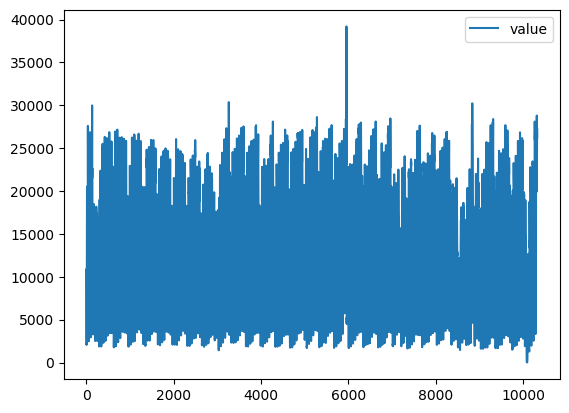

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

pedestrian_data.plot()

Human beings are also extraordinarily good at perceiving patterns. Note, for example, that something uncharacteristic occurs at around datapoint number 6000. Additionally, as we might expect with pedestrian walking patters, the number of pedestrians appears more or less periodic. Let's zoom in to not only examine this anomaly but also to get a better picture of what the "normal" data looks like.

### Code Cell 5

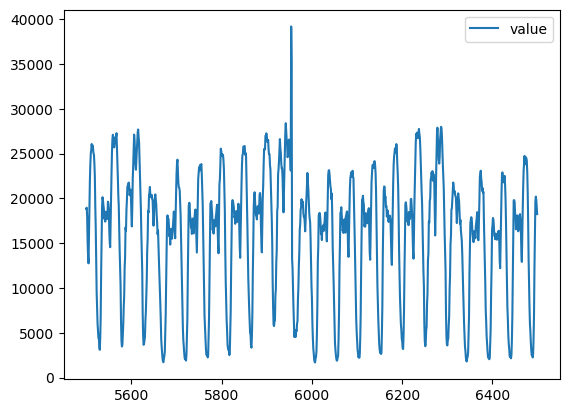

In [7]:
pedestrian_data[5500:6500].plot()

Here we see that the number of pedestrians walking around is mostly periodic with one mode of length approximately 50 data points. In fact, the mode is length 48 since each datapoint represents a 30-minute bin of pedestrians count. Therefore, we expect another mode of length $336 = 48 \times 7$, the length of a week. Smaller frequencies over the course of the day occur, as well.

__Note:__ The time slice in the above plot represents approximately the dates Oct 23rd 2014 to Nov 13th 2014.

For example, here is the data across the day containing the above anomaly:

### Code Cell 6

In [8]:
pedestrian_data[5952:6000]

,timestamp,value
5952,2014-11-02 00:00:00,25110
5953,2014-11-02 00:30:00,23109
5954,2014-11-02 01:00:00,39197
5955,2014-11-02 01:30:00,35212
5956,2014-11-02 02:00:00,13259
5957,2014-11-02 02:30:00,12250
5958,2014-11-02 03:00:00,10013
5959,2014-11-02 03:30:00,7898
5960,2014-11-02 04:00:00,6375
5961,2014-11-02 04:30:00,4532


Basic statistics for the whole data set will give us additional insights.  This can easily be accomplished by applying the describe() function on the data frame. Once you execute the below code you will get the following additional information: 


* `count` - Total number of data points.
* `mean` - The average number of pedestrians every half hour.
* `std` - Standard deviation.
* `min` - The minimium number of pedestrians during a given half hour period.
* `max` - The maximum number of pedestrians during a given half hour period.
* `50%` - The 50th percentile or the median. 


### Code Cell 7

In [9]:
pedestrian_data.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the pedestrian data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

### Code Cell 8

In [10]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=200,
    num_trees=50,
    base_job_name = f"rcf-train-lab-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(pedestrian_data.value.to_numpy().reshape(-1, 1)))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: rcf-train-lab-2023-06-18-01-13-19-2023-06-18-01-13-19-641


2023-06-18 01:13:20 Starting - Starting the training job...
2023-06-18 01:13:35 Starting - Preparing the instances for training......
2023-06-18 01:14:47 Downloading - Downloading input data...
2023-06-18 01:15:12 Training - Downloading the training image............
2023-06-18 01:17:23 Training - Training image download completed. Training in progress....
2023-06-18 01:17:53 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[06/18/2023 01:17:46 INFO 140567177127744] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[06/18/

When you see the message

> `===== Training job completed =====`


at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

### Code Cell 9

In [11]:
import boto3
print(f"Training job name: {rcf.latest_training_job.job_name}")


Training job name: rcf-train-lab-2023-06-18-01-13-19-2023-06-18-01-13-19-641


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

### Code Cell 10

In [12]:
endpoint_name = f"rcf-endpoint-lab-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge", endpoint_name = endpoint_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: rcf-train-lab-2023-06-18-01-13-19-2023-06-18-01-24-15-394
INFO:sagemaker:Creating endpoint-config with name rcf-endpoint-lab-2023-06-18-01-24-15
INFO:sagemaker:Creating endpoint with name rcf-endpoint-lab-2023-06-18-01-24-15


----------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

### Code Cell 11

In [14]:
print(f"Endpoint name: {rcf_inference.endpoint}")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: rcf-endpoint-lab-2023-06-18-01-24-15


## Data Serialization/Deserialization

You can pass data in a variety of formats to our inference endpoint. In this example you will pass CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. You will make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

### Code Cell 12

In [15]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()



Let's pass the training dataset, in CSV format, to the inference endpoint so you can automatically detect the anomalies you saw in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only view the anomaly scores for the first few data points to see what the output looks like.

### Code Cell 13

In [16]:
pedestrian_data_numpy = pedestrian_data.value.to_numpy().reshape(-1, 1)
results = rcf_inference.predict(pedestrian_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
pedestrian_data["score"] = pd.Series(scores, index=pedestrian_data.index)
pedestrian_data.head()



,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.916161
1,2014-07-01 00:30:00,8127,1.021837
2,2014-07-01 01:00:00,6210,0.968089
3,2014-07-01 01:30:00,4656,0.905840
4,2014-07-01 02:00:00,3820,0.964866


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire pedestrian dataset.

### Code Cell 14

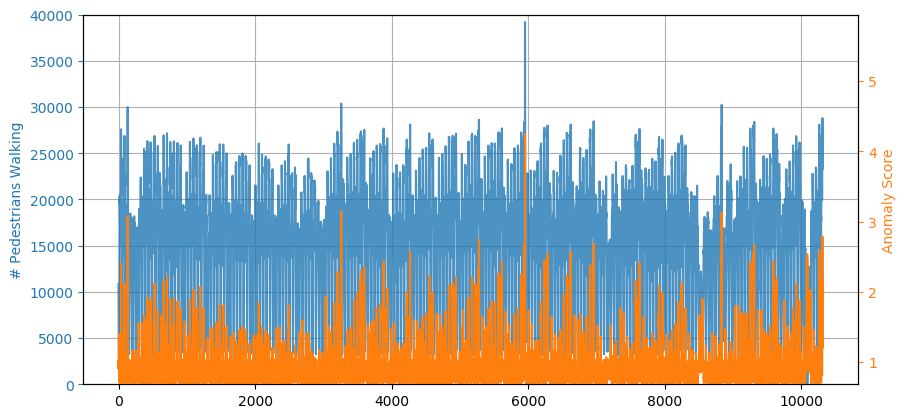

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(pedestrian_data)
# start, end = 5500, 6500
pedestrian_data_subset = pedestrian_data[start:end]

ax1.plot(pedestrian_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(pedestrian_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("# Pedestrians Walking", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

### Code Cell 15

In [18]:
score_mean = pedestrian_data["score"].mean()
score_std = pedestrian_data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = pedestrian_data_subset[pedestrian_data_subset["score"] > score_cutoff]
anomalies

,timestamp,value,score
37,2014-07-01 18:30:00,27598,2.404601
38,2014-07-01 19:00:00,26827,2.107586
87,2014-07-02 19:30:00,26872,2.119359
134,2014-07-03 19:00:00,29985,3.081246
423,2014-07-09 19:30:00,26319,1.921956
...,...,...,...
10310,2015-01-31 19:00:00,28804,2.785361
10311,2015-01-31 19:30:00,27773,2.453980
10317,2015-01-31 22:30:00,27309,2.273433
10318,2015-01-31 23:00:00,26591,2.022399


The following is a list of known anomalous events which occurred on the island within this timeframe:

* `2014-11-02` - Island Marathon
* `2015-01-01` - New Year's Eve
* `2015-01-27` - Tropical Storm

Note that our algorithm managed to capture these events along with quite a few others. Below you will add these anomalies to the score plot.

### Code Cell 16

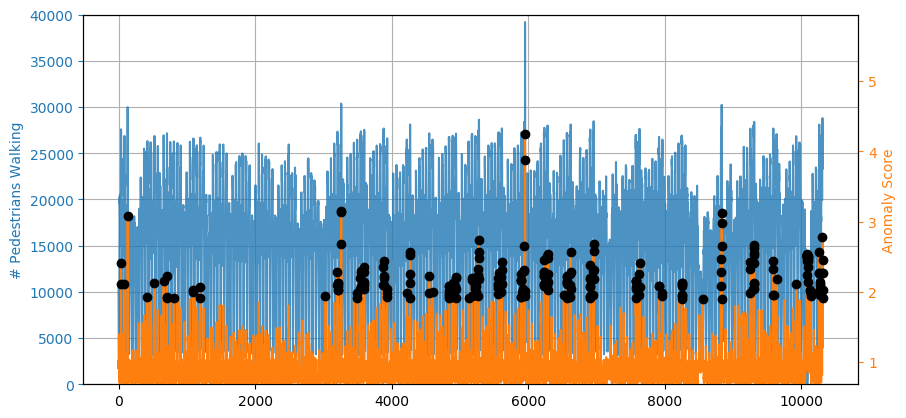

In [19]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

With the current hyperparameter choices notice that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the pedestrian plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, you should delete the endpoint before closing the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

### Code Cell 17

In [ ]:
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

### References

[2] https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html

https://sagemaker-workshop.com/builtin/rcf.html

https://freecontent.manning.com/the-randomcutforest-algorithm/

https://medium.com/analytics-vidhya/random-cut-forest-321aae4d8a59


